In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as skl
import ISLP
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

Final Project

First: Data Cleaning. Convert Year to an integer type where possible.
Check for duplicates and remove them. Missing values inculde "Year" and "Publisher". Year: Missing values were filled with the median year. Publisher: Missing values were replaced with "Unknown."

In [8]:
# Data Cleaning
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#vg_sales = pd.read_csv('/Users/sophiaguo/Desktop/EMORY/senior/QTM 347/vgsales.csv')
vg_sales = pd.read_csv('/Users/dell/Desktop/QTM_347/final/vgsales.csv')
vg_sales.head()
vg_sales.info()

duplicates = vg_sales.duplicated().sum()

# Handle missing values： “Year” and “Publisher”
vg_sales['Year'] = vg_sales['Year'].fillna(vg_sales['Year'].median())
vg_sales['Publisher'] = vg_sales['Publisher'].fillna('Unknown')
vg_sales['Year'] = vg_sales['Year'].astype(int)

cleaned_summary = {
    "Duplicates Removed": duplicates,
    "Missing Values (Post-Cleaning)": vg_sales.isnull().sum().to_dict(),
}

descriptive_stats = vg_sales.describe()

print("Data Cleaning Summary:", cleaned_summary)
print("Descriptive Statistics:", descriptive_stats)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
Data Cleaning Summary: {'Duplicates Removed': np.int64(0), 'Missing Values (Post-Cleaning)': {'Rank': 0, 'Name': 0, 'Platform': 0, 'Year': 0, 'Genre': 0, 'Publisher': 0, 'NA_Sales': 0, 'EU_Sales': 0, 'JP_Sales': 0, 'Other_Sales': 0, 'Global_Sales': 0}}
Descriptive Stati

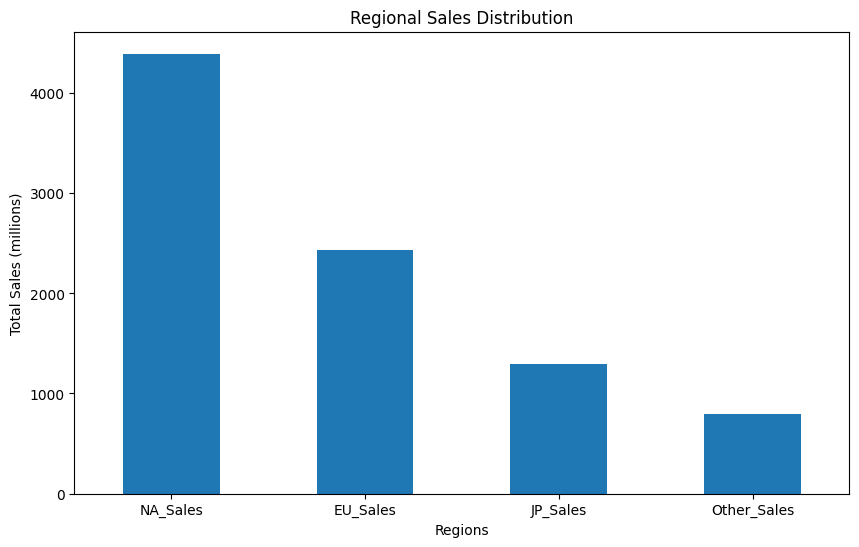

In [9]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
region_sales = vg_sales[regions].sum()

# Plot Regional Sales Distribution
plt.figure(figsize=(10, 6))
region_sales.plot(kind='bar')
plt.title("Regional Sales Distribution")
plt.xlabel("Regions")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=0)
plt.show()

In [10]:
vg_sales["Rank"]
import pandas as pd

# Assuming vg_sales is the dataset and it contains the 'Rank' column

# Define the categories and their labels
rank_categories = ['Very High', 'High', 'Medium', 'Low', 'Very Low']

# Categorize 'Rank' into five categories based on quantiles
vg_sales['Rank_Category'] = pd.qcut(
    vg_sales['Rank'], 
    q=5, 
    labels=rank_categories
)

# Display the first few rows to verify the categorization
print(vg_sales[['Rank', 'Rank_Category']].head())
vg_sales["Rank_Category"]

   Rank Rank_Category
0     1     Very High
1     2     Very High
2     3     Very High
3     4     Very High
4     5     Very High


0        Very High
1        Very High
2        Very High
3        Very High
4        Very High
           ...    
16593     Very Low
16594     Very Low
16595     Very Low
16596     Very Low
16597     Very Low
Name: Rank_Category, Length: 16598, dtype: category
Categories (5, object): ['Very High' < 'High' < 'Medium' < 'Low' < 'Very Low']

Jessie note: I want to utilize the categorical data as well. To do that, We need to get rid of a lot of the publishers and apply one hot encoding

Notation dictionary:

vg_sales_new = df that selected the publishers -> use this for analytics
vg_sales_unwanted = df that contains the games that contain the less popular publishers, just for the sake of double checking
vg_sales_encoded = df that chose the top 10% publisher,and have been encoded
vg_sales_ready = all numerical columns, dropped the original categorical columns and rank and name -> use this for machine learning 


In [11]:
# #To get an idea of the values of sales
# sales_data = vg_sales[['NA_Sales','EU_Sales',"JP_Sales",'Other_Sales','Global_Sales']]

# summary_table = sales_data.describe().transpose()

# summary_table['Mode'] = sales_data.mode().iloc[0]  # Taking the first mode for each column

# print(summary_table)

In [12]:
unique_count = vg_sales['Publisher'].nunique()
print(f"Unique count for publisher ': {unique_count}")

Unique count for publisher ': 578


We need to convert categorical data into encoded columns. However, we have noticed that the publisher column has too many categories. For the sake of simplicity of the project. 

In [13]:
# Calculate frequency and percentage
freq_pub = vg_sales['Publisher'].value_counts().reset_index()
freq_pub.columns = ['Publisher', 'Frequency']
freq_pub['Percent'] = (freq_pub['Frequency'] / len(vg_sales)) * 100

freq_year = freq_pub.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

print(freq_pub)


                        Publisher  Frequency   Percent
0                 Electronic Arts       1351  8.139535
1                      Activision        975  5.874202
2              Namco Bandai Games        932  5.615134
3                         Ubisoft        921  5.548861
4    Konami Digital Entertainment        832  5.012652
..                            ...        ...       ...
573                          Warp          1  0.006025
574                           New          1  0.006025
575                         Elite          1  0.006025
576               Evolution Games          1  0.006025
577             UIG Entertainment          1  0.006025

[578 rows x 3 columns]


In [14]:
filtered_freq_pub = freq_pub[(freq_pub['Frequency'] > 30) & (freq_pub['Frequency'] < 50)]

print(filtered_freq_pub)

             Publisher  Frequency   Percent
46   DTP Entertainment         45  0.271117
47      GT Interactive         45  0.271117
48           Destineer         45  0.271117
49           Alchemist         43  0.259067
50           MTV Games         41  0.247018
51               PQube         39  0.234968
52         Global Star         39  0.234968
53         Takara Tomy         37  0.222918
54     SouthPeak Games         37  0.222918
55               Spike         37  0.222918
56      TDK Mediactive         36  0.216894
57                 3DO         36  0.216894
58        Nordic Games         35  0.210869
59  BAM! Entertainment         35  0.210869
60    Black Bean Games         34  0.204844
61           Zoo Games         33  0.198819
62        Game Factory         32  0.192794
63           Psygnosis         32  0.192794
64           Mindscape         32  0.192794


In [15]:
mean_percent = freq_pub['Percent'].mean()
median_percent = freq_pub['Percent'].median()
percentile_90 = freq_pub['Percent'].quantile(0.90)

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median','Top 10% Percent'],
    'Percentage': [mean_percent, median_percent,percentile_90]
})
print(summary_table)


#top 75% is 0.06, 10 games

         Statistic  Percentage
0             Mean    0.173010
1           Median    0.018074
2  Top 10% Percent    0.212676


We will be using a cut-off threshold of 0.21%, which is the top10% publisher based on number of games they have produced. This also the selected larger publishers published more than 35 games.


In [16]:
selected_publisher = freq_pub[freq_pub['Percent'] > 0.21]
print(selected_publisher.shape)
unwanted_publisher=freq_pub[freq_pub['Percent']<=0.21]

(60, 3)


In [17]:
vg_sales_new = vg_sales[vg_sales['Publisher'].isin(selected_publisher['Publisher'])]
vg_sales.shape # 16598,11
vg_sales_new.shape  # 13806,11
# 15449,11 when top 25%

(13806, 12)

In [18]:
#count unique platform 
unique_platform = vg_sales['Platform'].nunique()
print(f"Unique count for platform: {unique_platform}")
#count unique genre
unique_genre = vg_sales['Genre'].nunique()
print(f"Unique count for genre: {unique_genre}")

Unique count for platform: 31
Unique count for genre: 12


In [19]:
#check if there are very popular games in the unwanted publishers list  _ ??? what if they are popular
vg_sales_unwanted = vg_sales[~vg_sales['Publisher'].isin(selected_publisher['Publisher'])]
vg_sales_unwanted_sorted = vg_sales_unwanted.sort_values(by='Global_Sales', ascending=False)
print(vg_sales_unwanted_sorted.head)

<bound method NDFrame.head of         Rank                                           Name Platform  Year  \
146      147                                 The Last of Us      PS3  2013   
167      168           Crash Bandicoot: The Wrath of Cortex      PS2  2001   
195      196                                 Guitar Hero II      PS2  2006   
242      243             Dragon Quest VII: Warriors of Eden       PS  2000   
276      277                   Teenage Mutant Ninja Turtles      NES  1989   
...      ...                                            ...      ...   ...   
16176  16179  San-X Character Channel: All-Star Daishuugou!       DS  2008   
16178  16181                                    Putty Squad      PS3  2013   
16180  16183                      Rozen Maiden: Gebetgarten      PS2  2007   
16183  16186                    Sakura-Sou no Pet na Kanojo      PSP  2013   
16597  16600                               Spirits & Spells      GBA  2003   

              Genre              

In [20]:
# #pie chart by region  and publisher

# import matplotlib.pyplot as plt

# # Grouping data by Publisher and summing up sales columns
# sales_by_publisher = vg_sales.groupby('Publisher')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# # Re-plotting with all data included but omitting titles for publishers with <5%
# for region in regions:
#     # Sorting by descending proportion for the current region
#     sorted_sales = sales_by_publisher[region].sort_values(ascending=False)
    
#     # Generate labels but omit the title for publishers contributing < 5%
#     total_sales = sorted_sales.sum()
#     labels = [
#         pub if sales / total_sales >= 0.05 else ""
#         for pub, sales in sorted_sales.items()
#     ]
    
#     # Plotting the pie chart
#     plt.figure(figsize=(6, 6))
#     plt.pie(
#         sorted_sales,
#         labels=labels,
#         autopct='%1.1f%%',
#         startangle=90
#     )
#     plt.title(f"{region} by Publisher")
#     plt.show()


In [21]:
from sklearn.preprocessing import OneHotEncoder


In [22]:
encoder = OneHotEncoder(sparse_output=False)  # Use `sparse_output=False` for an array output
onehotarray = encoder.fit_transform(vg_sales_new[["Publisher", "Genre", "Platform"]])

encoded_categories = []
for col, categories in zip(["Publisher", "Genre", "Platform"], encoder.categories_):
    encoded_categories.extend([f"{col}_{cat}" for cat in categories])

# Create a new DataFrame with the encoded columns
encoded_df = pd.DataFrame(onehotarray, columns=encoded_categories, index=vg_sales_new.index)

# Combine the original dataset with the encoded columns into a new dataset
vg_sales_encoded = pd.concat([vg_sales_new, encoded_df], axis=1)


print(vg_sales_encoded.columns)
#shape 13806,113

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales',
       ...
       'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_TG16',
       'Platform_WS', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne'],
      dtype='object', length=114)


In [23]:
columns_to_drop = ['Name', 'Rank', 'Platform', 'Publisher', 'Genre']
vg_sales_ready = vg_sales_encoded.drop(columns=columns_to_drop, errors='ignore')

#print(vg_sales_ready.columns)
print(vg_sales_ready)
#check all is numerical


       Year  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0      2006     41.49     29.02      3.77         8.46         82.74   
1      1985     29.08      3.58      6.81         0.77         40.24   
2      2008     15.85     12.88      3.79         3.31         35.82   
3      2009     15.75     11.01      3.28         2.96         33.00   
4      1996     11.27      8.89     10.22         1.00         31.37   
...     ...       ...       ...       ...          ...           ...   
16588  2008      0.01      0.00      0.00         0.00          0.01   
16591  2004      0.01      0.00      0.00         0.00          0.01   
16592  2008      0.01      0.00      0.00         0.00          0.01   
16594  2003      0.01      0.00      0.00         0.00          0.01   
16595  2008      0.00      0.00      0.00         0.00          0.01   

      Rank_Category  Publisher_3DO  Publisher_505 Games  Publisher_5pb  ...  \
0         Very High            0.0                  0.0 

In [24]:
vg_sales_ready = vg_sales_ready[vg_sales_ready['Global_Sales'] != 82.74]

In [25]:
all_numeric = vg_sales_ready.select_dtypes(include=['number']).shape[1] == vg_sales_ready.shape[1]

print(all_numeric)

False


logistic regression


In [26]:

# Define the mapping
rank_mapping = {
    "Very High": 5,
    "High": 4,
    "Medium": 3,
    "Low": 2,
    "Very Low": 1
}

# Apply the mapping to the Rank_Category column
vg_sales_ready["Rank_Category_num"] = vg_sales_ready["Rank_Category"].map(rank_mapping)



In [27]:
# # Count the frequency of each platform
# platform_counts = vg_sales['Platform'].value_counts()
# genre_counts=vg_sales['Genre'].value_counts()

# # Find the platform with the lowest frequency
# lowest_frequency_platform = platform_counts.idxmin()
# lowest_frequency_plt = platform_counts.min()

# lowest_frequency_genre= genre_counts.idxmin()
# lowest_frequency_gen = genre_counts.min()

# print(f"Platform with the lowest frequency: {lowest_frequency_platform}")
# print(f"Frequency: {lowest_frequency_plt}")

# print(f"Genre with the lowest frequency: {lowest_frequency_platform}")
# print(f"Frequency: {lowest_frequency_genre}")


In [28]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error

# # Prepare features (X)
# X = vg_sales_ready.drop(columns=["Global_Sales", "Rank_Category","NA_Sales","JP_Sales","EU_Sales","Other_Sales","Platform_GG","Genre_Puzzle"], axis=1)
# X = sm.add_constant(X)

# y = vg_sales_ready["Rank_Category_num"]

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Logistic Regression
# log_reg = LogisticRegression(random_state=42)
# log_reg.fit(X_train_scaled, y_train)

# # Predictions
# y_pred_log = log_reg.predict(X_test_scaled)

# # Evaluate the Model
# accuracy_log = accuracy_score(y_test, y_pred_log)
# print("Accuracy:", accuracy_log)
# print("Classification Report:\n", classification_report(y_test, y_pred_log))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# mse_logistic = mean_squared_error(y_test, y_pred_log)
# print("Logistic Regression Mean Squared Error:", mse_logistic)
# #weird result

Lasso

In [29]:
import sklearn.linear_model as skl
import ISLP
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm

In [30]:
K=5
kfold = skm.KFold(K, random_state=37, shuffle=True) #dont forget to set the random state so that you can same results everytime. 

In [53]:
# Split the data into features (X) and target (y)
X = vg_sales_ready.drop(columns=["Global_Sales","Rank_Category",'NA_Sales',"EU_Sales","JP_Sales","Other_Sales","Platform_GG","Genre_Puzzle","Rank_Category_num"], axis=1)
#X = vg_sales_ready.drop(columns=["Global_Sales","Rank_Category"], axis=1) #mse too big

X = sm.add_constant(X)
y = vg_sales_ready["Global_Sales"]

# Split into train and test sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled_lasso = scaler.fit_transform(X_train_lasso)
X_test_scaled_lasso = scaler.transform(X_test_lasso)

# Perform Lasso regression with cross-validation to select alpha
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled_lasso, y_train_lasso)

# Predict on the test set
y_pred_lasso = lasso.predict(X_test_scaled_lasso)

# Evaluate the model
mse = mean_squared_error(y_test_lasso, y_pred_lasso)
print("Mean Squared Error:", mse)
print("Best alpha:", lasso.alpha_)

# Display coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_
})
#print(coefficients)


#store mse lasso in a variable
mse_lasso = mean_squared_error(y_test_lasso, y_pred_lasso)

Mean Squared Error: 1.8620112567326124
Best alpha: 0.0016534118155090915


In [32]:
# Display coefficients sorted in descending order
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_
})

# Sort the coefficients by value in descending order
coefficients_sorted = coefficients.sort_values(by="Coefficient", ascending=False)

# Display the top 10 coefficients
top_10_coefficients = coefficients_sorted.head(10)
print("Top 10 Features by Coefficient:")
print(top_10_coefficients)



Top 10 Features by Coefficient:
                                  Feature  Coefficient
40                     Publisher_Nintendo     0.449162
22              Publisher_Electronic Arts     0.132625
99                          Platform_X360     0.112254
89                           Platform_PS4     0.109973
88                           Platform_PS3     0.108945
54         Publisher_Take-Two Interactive     0.095138
37       Publisher_Microsoft Game Studios     0.093647
97                           Platform_Wii     0.087767
66                         Genre_Platform     0.083502
46  Publisher_Sony Computer Entertainment     0.082523


In [33]:
import statsmodels.api as sm

# Refit the model using statsmodels for statistical testing
lasso_stats = sm.OLS(y_train_lasso, X_train_lasso).fit()




# Display the summary
print(lasso_stats.summary())

# Extract p-values for coefficients
p_values = lasso_stats.pvalues

significant_features = p_values[p_values < 0.05].index  # Features with p-value < 0.05
print("Statistically significant features:", significant_features)


                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     18.53
Date:                Sun, 08 Dec 2024   Prob (F-statistic):          5.18e-293
Time:                        23:51:34   Log-Likelihood:                -19654.
No. Observations:               11044   AIC:                         3.951e+04
Df Residuals:                   10943   BIC:                         4.025e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [34]:
# Refit the model using statsmodels for statistical testing
lasso_stats = sm.OLS(y_train_lasso, X_train_lasso).fit()

# Get the summary of coefficients and p-values
coefficients_stats = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_stats.params,
    "P-value": lasso_stats.pvalues
})

# Sort by descending coefficient value
coefficients_sorted_by_value = coefficients_stats.sort_values(by="Coefficient", ascending=False)
print("Coefficients sorted by value:")
print(coefficients_sorted_by_value.head(10))

# Sort by ascending P-value
coefficients_sorted_by_significance = coefficients_stats.sort_values(by="P-value", ascending=True)
print("Coefficients sorted by significance (P-value):")
print(coefficients_sorted_by_significance.head(10))


Coefficients sorted by value:
                                                           Feature  \
const                                                        const   
Publisher_Nintendo                              Publisher_Nintendo   
Platform_GB                                            Platform_GB   
Publisher_Microsoft Game Studios  Publisher_Microsoft Game Studios   
Publisher_Bethesda Softworks          Publisher_Bethesda Softworks   
Platform_PS4                                          Platform_PS4   
Publisher_LucasArts                            Publisher_LucasArts   
Publisher_Take-Two Interactive      Publisher_Take-Two Interactive   
Platform_XOne                                        Platform_XOne   
Publisher_Electronic Arts                Publisher_Electronic Arts   

                                  Coefficient       P-value  
const                               73.802865  6.883157e-10  
Publisher_Nintendo                   3.238865  2.595027e-53  
Platform_GB  

In [35]:
variance_global_sales = y_test_lasso.var()
print("Variance of Global Sales:", variance_global_sales)


Variance of Global Sales: 2.153047746195718


Gradient Boosting

In [38]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
# Lasso Predictions
y_pred_lasso = lasso.predict(X_test_scaled_lasso)

# # Lasso MSE
# mse_lasso = mean_squared_error(y_test_lasso, y_pred_lasso)
# print("Lasso Mean Squared Error:", mse_lasso)

# Get selected features (non-zero coefficients)
selected_features = X.columns[lasso.coef_ != 0]
print("Selected features by Lasso:", selected_features)

# Reduce the dataset to selected features
X_train_selected = X_train_scaled_lasso[:, lasso.coef_ != 0]
X_test_selected = X_test_scaled_lasso[:, lasso.coef_ != 0]

# Step 2: Apply Gradient Boosting on Selected Features
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train_selected, y_train_lasso)

# Gradient Boosting Predictions
y_pred_gbr = gbr.predict(X_test_selected)


Selected features by Lasso: Index(['Year', 'Publisher_3DO', 'Publisher_505 Games', 'Publisher_5pb',
       'Publisher_Acclaim Entertainment', 'Publisher_Activision',
       'Publisher_Alchemist', 'Publisher_Atari', 'Publisher_Atlus',
       'Publisher_BAM! Entertainment', 'Publisher_Banpresto',
       'Publisher_Bethesda Softworks', 'Publisher_Capcom',
       'Publisher_Codemasters', 'Publisher_Crave Entertainment',
       'Publisher_D3Publisher', 'Publisher_DTP Entertainment',
       'Publisher_Deep Silver', 'Publisher_Destineer',
       'Publisher_Disney Interactive Studios', 'Publisher_Eidos Interactive',
       'Publisher_Electronic Arts', 'Publisher_Empire Interactive',
       'Publisher_Focus Home Interactive', 'Publisher_Global Star',
       'Publisher_Hudson Soft', 'Publisher_Idea Factory',
       'Publisher_Ignition Entertainment', 'Publisher_Infogrames',
       'Publisher_Kadokawa Shoten', 'Publisher_Konami Digital Entertainment',
       'Publisher_LucasArts', 'Publisher_MTV 

In [39]:
#print top 5 publisher and platform
#top 5 publishers
top_5_publishers = freq_pub.head(10)
print("Top 5 Publishers:")
print(top_5_publishers)
#top 5 platforms
freq_platforms = vg_sales['Platform'].value_counts()
top_5_platforms = freq_platforms.head(5)
print("Top 5 Platforms:")
print(top_5_platforms)

Top 5 Publishers:
                      Publisher  Frequency   Percent
0               Electronic Arts       1351  8.139535
1                    Activision        975  5.874202
2            Namco Bandai Games        932  5.615134
3                       Ubisoft        921  5.548861
4  Konami Digital Entertainment        832  5.012652
5                           THQ        715  4.307748
6                      Nintendo        703  4.235450
7   Sony Computer Entertainment        683  4.114954
8                          Sega        639  3.849861
9          Take-Two Interactive        413  2.488252
Top 5 Platforms:
Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
Name: count, dtype: int64


In [40]:
# Top publishers by sum of Global_Sales
top_publishers_by_sales = vg_sales.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

# Select the top 5 publishers
top_5_publishers_by_sales = top_publishers_by_sales.head(5)
print("Top 5 Publishers by Global Sales:")
print(top_5_publishers_by_sales)

# Top platforms by sum of Global_Sales
top_platforms_by_sales = vg_sales.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

# Select the top 5 platforms
top_5_platforms_by_sales = top_platforms_by_sales.head(5)
print("\nTop 5 Platforms by Global Sales:")
print(top_5_platforms_by_sales)


Top 5 Publishers by Global Sales:
Publisher
Nintendo                       1786.56
Electronic Arts                1110.32
Activision                      727.46
Sony Computer Entertainment     607.50
Ubisoft                         474.72
Name: Global_Sales, dtype: float64

Top 5 Platforms by Global Sales:
Platform
PS2     1255.64
X360     979.96
PS3      957.84
Wii      926.71
DS       822.49
Name: Global_Sales, dtype: float64


In [41]:
# Gradient Boosting MSE
mse_gbr = mean_squared_error(y_test_lasso, y_pred_gbr)
print("Gradient Boosting Mean Squared Error:", mse_gbr)

Gradient Boosting Mean Squared Error: 1.825100040118374


In [48]:

#count the selected feature
selected_feature_count = len(selected_features)
print(selected_feature_count)

95


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the Gradient Boosting Regressor
mse_gbr = mean_squared_error(y_test_lasso, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test_lasso, y_pred_gbr)
r2_gbr = r2_score(y_test_lasso, y_pred_gbr)

print("Gradient Boosting Regressor Metrics:")
print("Mean Squared Error (MSE):", mse_gbr)

print("Mean Absolute Error (MAE):", mae_gbr)
print("R² Score:", r2_gbr)


Gradient Boosting Regressor Metrics:
Mean Squared Error (MSE): 1.825100040118374
Mean Absolute Error (MAE): 0.5581607231706377
R² Score: 0.15201076637764221


In [54]:
from scipy.stats import ttest_rel
# Absolute difference
mse_diff = abs(mse_gbr - mse_lasso)
print("Absolute Difference in MSE:", mse_diff)

# Calculate prediction errors
error_gbr = y_test_lasso - y_pred_gbr
error_lasso = y_test_lasso - y_pred_lasso

# Perform paired t-test
t_stat, p_value = ttest_rel(error_gbr, error_lasso)
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpretation of p-value
if p_value < 0.05:
    print("The difference in MSE is statistically significant.")
else:
    print("The difference in MSE is not statistically significant.")


Absolute Difference in MSE: 0.03691121661423846
T-statistic: 0.34456928861306957
P-value: 0.730444449878142
The difference in MSE is not statistically significant.


Gradient boosting can model more complex patterns but is prone to overfitting, especially with limited data or poorly selected features.
Lasso, being a linear model with regularization, is less flexible but might generalize better.
Maybe our dataset lacks the complexity thats more suitable for gradient boosting.
The lasso model already captures the key patterns effectively.

In [ ]:
# # Check for columns containing string values
# string_columns = []

# for column in X.columns:
#     # Check if any value in the column is of type string
#     if X[column].apply(lambda x: isinstance(x, str)).any():
#         string_columns.append(column)

# print("Columns containing string values:")
# print(string_columns)


Columns containing string values:
['Rank_Category']


In [44]:
lassoCV = skl.ElasticNetCV(
    n_alphas=100, 
#     alphas=lambdas,#manually set the alpha. either way is fine 
                           l1_ratio=1, 
                           
                           cv=kfold)           


In [45]:
from sklearn.pipeline import Pipeline
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)]) #standardize before using lasso
#pipeCV.fit(X, Y)

pipeCV

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=37, shuffle=True),
                              l1_ratio=1))])

In [ ]:

X = vg_sales_ready.drop(columns=["Global_Sales","Rank_Category",'NA_Sales',"EU_Sales","JP_Sales","Other_Sales",'Rank_Category_num'], axis=1)
y = vg_sales_ready["Global_Sales"]
pipeCV.fit(X,y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

np.float64(0.002748149154977806)

In [ ]:
#feature standarization
#After this transformation, Xs is a scaled version of the original data X.

# Assuming X is a pandas DataFrame
X_np = X.values  # Convert pandas DataFrame to NumPy array

# Perform standardization
Xs = X_np - X_np.mean(0)[None, :]  # Subtract column-wise mean
X_scale = X_np.std(0)              # Compute column-wise standard deviation
Xs = Xs / X_scale[None, :]         # Divide by standard deviation

print(Xs)

[[-0.09360928 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]
 [-3.89044257 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]
 [ 0.26799389 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]
 ...
 [ 0.26799389 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]
 [-0.63601404 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]
 [ 0.26799389 -0.051131   -0.1187566  ... -0.30101075 -0.23950755
  -0.11686055]]


In [ ]:
import patsy
import numpy as np

In [ ]:


# Replace spaces with underscores in column names
vg_sales_ready.columns = vg_sales_ready.columns.str.replace(r'[^\w]', '_', regex=True) 
#one of the publisher _Tecmo Koei has inherent space invalid syntax

formula = ' + '.join(vg_sales_ready.columns.drop(labels=['Global_Sales', "Rank_Category", 'NA_Sales', "EU_Sales", "JP_Sales", "Other_Sales","Rank_Category_num"]))

# Create the design matrix
D = patsy.dmatrix(formula, data=vg_sales_ready.drop(columns=["Global_Sales", "Rank_Category", 'NA_Sales', "EU_Sales", "JP_Sales", "Other_Sales","Rank_Category_num"], axis=1), return_type='dataframe')

# Drop the intercept column if it exists
if 'Intercept' in D.columns:
    D = D.drop('Intercept', axis=1)

# Display the column names of the resulting design matrix
print(D.columns)

# Show the first few rows of the design matrix for inspection
D.head()

Index(['Year', 'Publisher_3DO', 'Publisher_505_Games', 'Publisher_5pb',
       'Publisher_Acclaim_Entertainment', 'Publisher_Activision',
       'Publisher_Alchemist', 'Publisher_Atari', 'Publisher_Atlus',
       'Publisher_BAM__Entertainment',
       ...
       'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_TG16',
       'Platform_WS', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne'],
      dtype='object', length=103)


,Year,Publisher_3DO,Publisher_505_Games,Publisher_5pb,Publisher_Acclaim_Entertainment,Publisher_Activision,Publisher_Alchemist,Publisher_Atari,Publisher_Atlus,Publisher_BAM__Entertainment,...,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
0,2006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1985.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lambdas, soln_array = skl.Lasso.path(Xs, y, 
                                      l1_ratio=1,  #same as above 
                                      n_alphas=100)[:2]
#soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=lambdas)

#get rid of nan
soln_path = soln_path.dropna(axis=1)


<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
/var/folders/nr/tkxm_1912292k5dbxrmqfv4m0000gn/T/ipykernel_3511/3501632259.py:27: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$', fontsize=20)


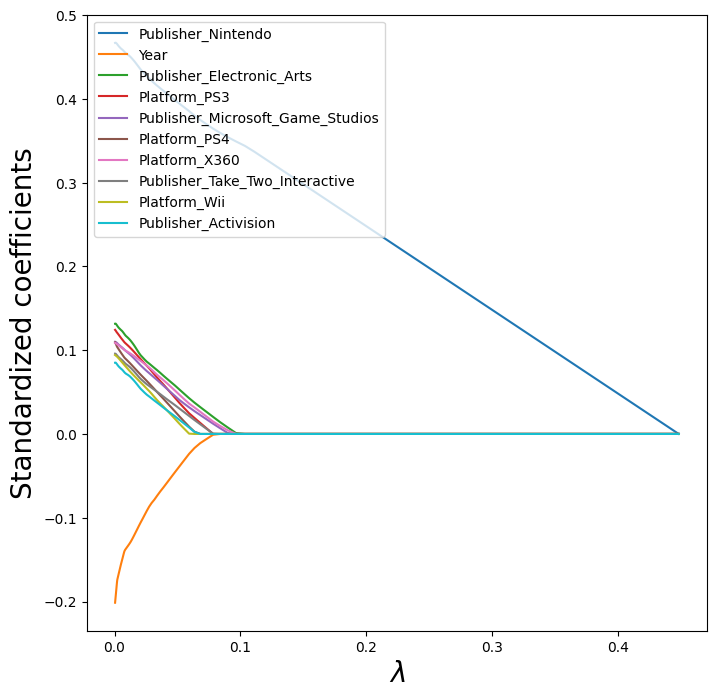

In [ ]:
#import matplotlib.pyplot as plt

# path_fig, ax = plt.subplots(figsize=(8,8))
# soln_path.plot(ax=ax, legend=False)
# ax.legend(loc='upper left')
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Standardized coefficiients', fontsize=20);


#coefficient go to zero
#!!!plot only top ones
#!! delete the [0]


top_10_contributors = soln_path.abs().max(axis=0).nlargest(10).index

# Filter the soln_path DataFrame to include only the top 10 contributors
filtered_soln_path = soln_path[top_10_contributors]

# Plot the filtered data
path_fig, ax = plt.subplots(figsize=(8, 8))
filtered_soln_path.plot(ax=ax, legend=False)

# Adjust the legend and labels
ax.legend(loc='upper left', labels=top_10_contributors)
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_xlabel('$\lambda$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
plt.show()

In [ ]:
np.min(tuned_lasso.mse_path_.mean(1))
#

np.float64(3.413344217486955e-05)

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/nr/tkxm_1912292k5dbxrmqfv4m0000gn/T/ipykernel_2825/1751670902.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


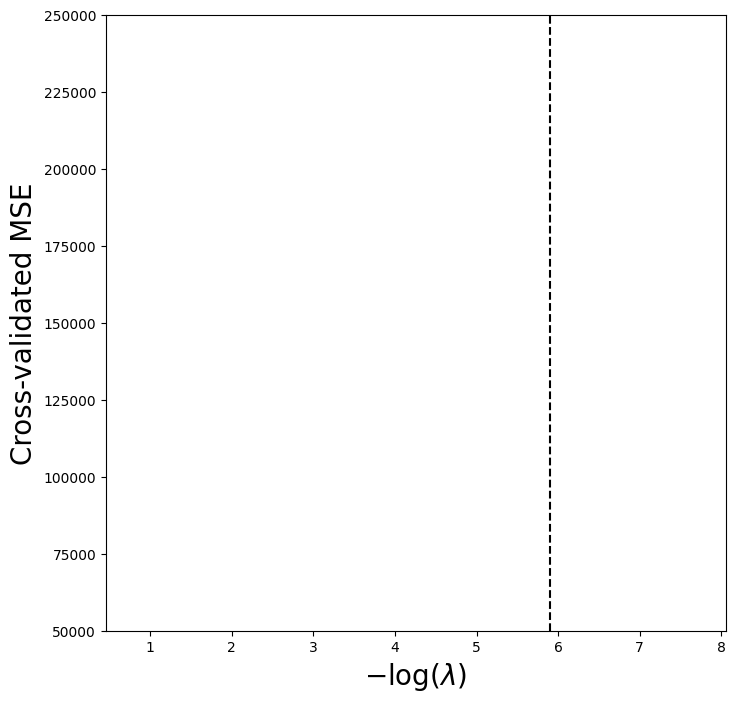

In [ ]:
# lassoCV_fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(-np.log(tuned_lasso.alphas_),
# tuned_lasso.mse_path_.mean(1),
# yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
# ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# ax.set_ylim([50000,250000])
# ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax.set_ylabel('Cross-validated MSE', fontsize=20);

# # not working???

In [ ]:
tuned_lasso.coef_

#some coefficient will be zero - advantage for this aproach 

array([-0.        ,  0.88428365,  0.54807768,  0.32432078,  0.20428118,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.  